In [45]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

from numpy.random import choice, normal

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import median_abs_deviation as mad

from local_utils import *
kappa = 0.4

# WS_file = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/WE__0133___________DER_WS__________________P01.xml'
which_sol = "0133"
path = './MEDA_WS_Data/'
WS_file = path + 'WE__%s___________DER_WS__________________P02.xml' % (which_sol)

time, wind = retrieve_time_wind(WS_file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing label: ./MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE


./MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml


NameError: name 'struct_list' is not defined

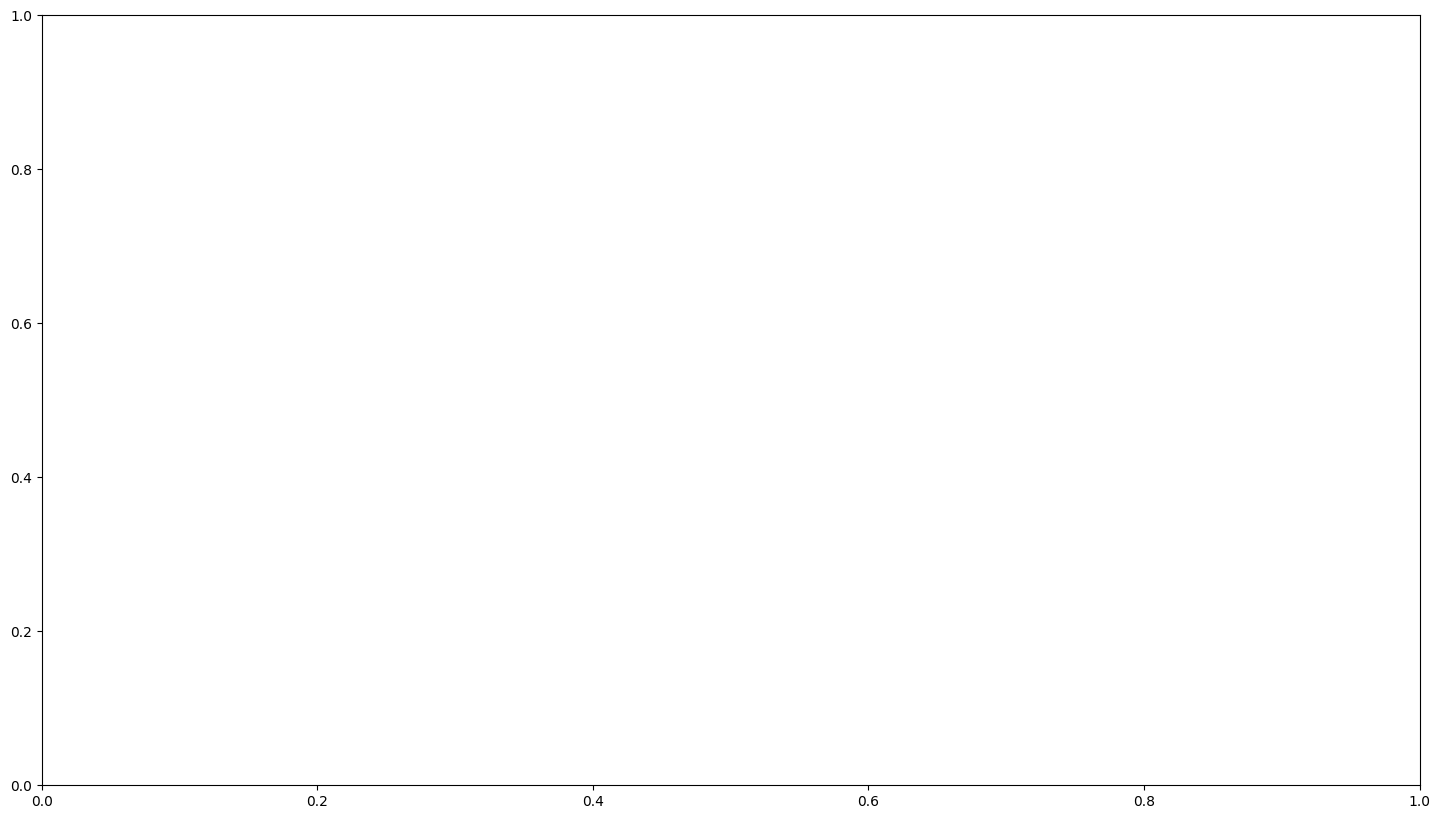

In [3]:
# When during the day should you fly?
# In terms of times after sunrise, probably between 6 and 9am.

WS_file = path + 'WE__%s___________DER_WS__________________P02.xml' % (which_sol)
print(WS_file)

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

time, wind = retrieve_time_wind(WS_file, start_time=None, end_time=None)
# ax.scatter(time, wind, marker='.', color=BoiseState_blue)
ax.scatter(time, wind, marker='.', color=BoiseState_blue)

xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
# ax.set_xlim([start_time, end_time])
# ax.set_xlim([datetime(1900, 1, 1, 7, 10, 0), datetime(1900, 1, 1, 7, 20, 0)])

# fig.savefig("Sol133_Windspeeds.jpg", dpi=300, bbox_inches="tight")

./MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
30.725532319628844


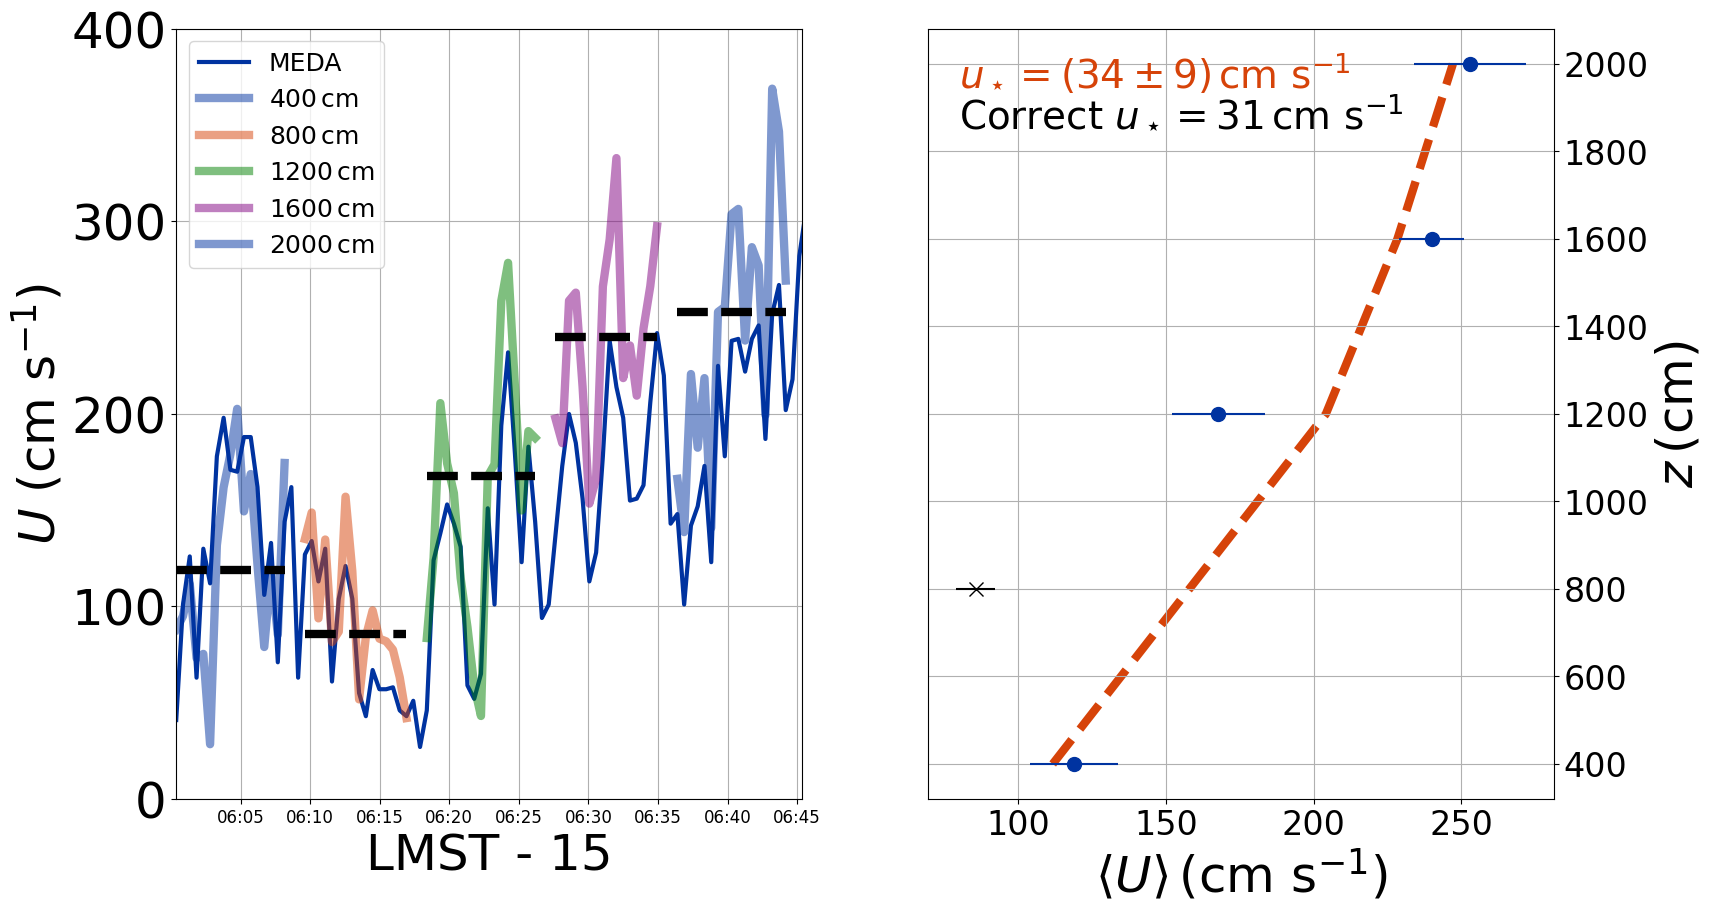

In [81]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# For sol 91, the wind speeds at 7a are pretty low. Let's try a little later when they pick up.
# time, wind = retrieve_time_wind(WS_file, start_time=datetime(1900, 1, 1, 7, 40, 0))

# For sol 107, the wind speeds at 7a are pretty low. Let's try a little later when they pick up.
# time, wind = retrieve_time_wind(WS_file, start_time=datetime(1900, 1, 1, 7, 20, 15))

print(WS_file)
# time, wind = retrieve_time_wind(WS_file, start_time=datetime(1900, 1, 1, 11, 6, 0), 
#                                 end_time=datetime(1900, 1, 1, 12, 6, 0))
# wind *= 100. # Convert to cm/s

# saved_zstar = 10. # cm
saved_zstar = 2. # cm
saved_ustar = kappa*np.mean(wind)/np.log(zs[0]/saved_zstar)

print(saved_ustar)

# Create synthetic wind profile, converting wind speeds to cm/s
scaled_windspeeds = create_synthetic_wind_profile(wind, zs, saved_zstar, z0=np.min(zs))

# 2023 Sep 13 - Brown tells me the drone samples at 500 Hz. 
# If we fold in a 6 m/s scatter but at 500 Hz for sampling, that works out to 
# \sigma = (6 m/s)/np.sqrt(500) = 0.3 m/s scatter on each data point
attitude_scatter = 600./np.sqrt(500.) # cm/s
for i in range(len(scaled_windspeeds[:,0])):
    scaled_windspeeds[i,:] += normal(scale=attitude_scatter, size=len(scaled_windspeeds[i,:]))

t0 = np.min(time)
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs,
                                                          settle_time=settle_time)

# Make plot of original and scaled wind speeds
# zs, time, sample_time, scaled_windspeeds, averaged_windspeeds, axis

ax1 = make_plot_of_original_and_scaled_windspeeds(time, wind, zs, sample_time, t0, scaled_windspeeds, 
                                                  averaged_windspeeds, ax1,
                                                  settle_time=settle_time)
ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=\
                                                     len(zs)*(sampling_duration + settle_time_seconds))])
ax1.set_ylim([0, 400])

### Fit synthetic wind profile ###

inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,\
    outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds,\
    popt, unc, pcov = fit_wind_profile_and_drop_outliers(zs, averaged_windspeeds, std_windspeeds,
                                                         drop_outliers=True, num_sigma=5., rescale_unc=False,
                                                         consider_scaled_uncertainties=False)

# Collect ustar and zstar and uncertainties
ustar, zstar, sigma_ustar, sigma_zstar = collect_fit_values_and_unc(popt, unc, pcov)

ax2 = make_plot_of_wind_data_and_profile(inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,
                                         outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds, 
                                         popt, unc, pcov, ax2)

ax2.text(0.05, 0.925, 
    r'$u_\star = \left( %.0f\pm%.0f \right)\,{\rm cm\ s^{-1}}$' %\
    (ustar, sigma_ustar), fontsize=28, transform=ax2.transAxes, 
    color=BoiseState_orange)
# ax2.text(0.05, 0.875, r'$z_\star = \left( %.2f\pm%.2f \right)\,{\rm cm}$' %\
#     (zstar, sigma_zstar), fontsize=28, transform=ax2.transAxes,
#     color=BoiseState_orange)

ax2.text(0.05, 0.875, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
         fontsize=28, transform=ax2.transAxes)

# ax2.text(0.05, 0.825, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
#          fontsize=28, transform=ax2.transAxes)
# ax2.text(0.05, 0.775, r'Correct $z_\star = %.0f\, {\rm cm}$' % (saved_zstar), 
#          fontsize=28, transform=ax2.transAxes)

fig.savefig("Synthetic_Mars_Wind_Profile_Sol133.jpg", dpi=300, bbox_inches="tight")

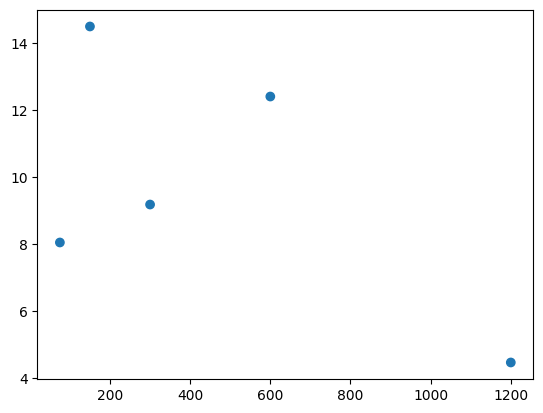

In [63]:
# time, wind = retrieve_time_wind(WS_file)
# wind *= 100. # Convert to cm/s

saved_zstar = 3. # cm
saved_ustar = kappa*np.mean(wind)/np.log(zs[0]/saved_zstar)

# Create synthetic wind profile, converting wind speeds to cm/s
# scaled_windspeeds = create_synthetic_wind_profile(wind, zs, saved_zstar, z0=np.min(zs))
t0 = np.min(time)

# Have NO wind profile scaling - just use the actual wind speeds
scaled_windspeeds = np.array([wind, wind, wind, wind, wind])
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)

# plt.errorbar(zs, averaged_windspeeds, yerr=std_windspeeds, ls='', marker='o')
plt.scatter(zs, averaged_windspeeds/inlier_std_windspeeds, ls='', marker='o')